<a href="https://colab.research.google.com/github/dmamur/elementsem/blob/main/notebooks/elembert_classification_matbenchV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from joblib import dump, load
def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model



In [ ]:
!pip install ase
!git clone https://github.com/dmamur/elementsem.git
!pip install icc_rt --no-deps
!git clone https://github.com/hackingmaterials/matbench
!pip install ./matbench
!pip install pydantic==1.10.12 --force-reinstall
!pip install pymatgen --force-reinstall

fatal: destination path 'elementsem' already exists and is not an empty directory.
fatal: destination path 'matbench' already exists and is not an empty directory.
Processing ./matbench
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matbench: filename=matbench-0.6-py3-none-any.whl size=5449481 sha256=440de0cddd288a580504153e0ddd1133333467c3afad6847738b30a517e7a4e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-33k4me8z/wheels/0d/71/69/39ae3b7c60edd18e46ed290a09bc2fe0c344372520cd165c70
Successfully built matbench
  Attempting uninstall: matbench
    Found existing installation: matbench 0.6
    Uninstalling matbench-0.6:
      Successfully uninstalled matbench-0.6
  Using cached pydantic-1.10.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Attempting uninstall: typing-extensions
    Found e

  Using cached pymatgen-2023.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.0 MB/s eta 0:00:00
  Using cached monty-2023.9.5-py3-none-any.whl (65 kB)
  Using cached mp_api-0.35.1-py3-none-any.whl (97 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 18.1 MB/s eta 0:00:00
  Using cached palettable-3.3.3-py2.py3-none-any.whl (332 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 110.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 102.6 MB/s eta 0:00:00
  Using cached pybtex-0.24.0-py2.py3-none-any.whl (561 kB)
  Using cached pydantic-1.10.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.6 MB/s eta 0:00:00
  Using cached ruamel.yaml-0.17.32-py3-none-any.whl (112 kB)
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 128
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembertR_'
    MVER = 'V0'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)

def getTypesXYZ(file):
    xyz,types=[],[]
    lattice=file['lattice']['matrix']
    for n in file['sites']:
        types.append(n['label'])
        xyz.append(n['xyz'])
    return ['[CLS]']+types+['[SEP]'],lattice,np.asarray(xyz)

def getModelInputs(inputs):
    typesLst,pdfAtoms = [],[]
    for i0,i in enumerate(inputs):
        types,lattice,coords=getTypesXYZ(i.as_dict())
        typesLst.append([element2id[i] for i in types])
    return typesLst

vocabSize:  101


# Define model

In [ ]:
inputC = Input((config.MAX_LEN), dtype=tf.int64,name='types')

z = create_elembert_model(inputC,config)

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(2, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 types (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 element_embdgs (Embedding)     (None, 128, 32)      3232        ['types[0][0]']                  
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 128, 32)     0           ['element_embdgs[0][0]']         
 da)                                                                                              
                                                                                                  
 encoder_0/multiheadattention (  (None, 128, 32)     4224        ['tf.__operators__.add[0][0]'

# Matbench: is_metal task

In [ ]:
from matbench.bench import MatbenchBenchmark
from ase import Atoms
from ase.io import read,write

mb = MatbenchBenchmark(autoload=True,subset=["matbench_mp_is_metal"])


Fetching matbench_mp_is_metal.json.gz from https://ml.materialsproject.org/projects/matbench_mp_is_metal.json.gz to /usr/local/lib/python3.10/dist-packages/matminer/datasets/matbench_mp_is_metal.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_mp_is_metal.json.gz in MB: 136.699904MB [00:00, 272.77MB/s]                                        


2023-09-05 18:54:51 INFO     Initialized benchmark 'matbench_v0.1' with 1 tasks: 
['matbench_mp_is_metal']


INFO:matbench:Initialized benchmark 'matbench_v0.1' with 1 tasks: 
['matbench_mp_is_metal']


In [ ]:
for task in mb.tasks:
    task.load()
    for fold in task.folds:
        print(fold)
        # Inputs are either chemical compositions as strings
        # or crystal structures as pymatgen.Structure objects.
        # Outputs are either floats (regression tasks) or bools (classification tasks)
        train_inputs, train_outputs = task.get_train_and_val_data(fold)
        typesLst = getModelInputs(train_inputs)
        x = tf.keras.preprocessing.sequence.pad_sequences(typesLst,dtype='int64',padding= 'post',truncating='post',maxlen=config.MAX_LEN)
        # train and validate your model
        labels=to_categorical(np.asarray(train_outputs.astype(int)))
        p = np.random.RandomState(seed=seed).permutation(len(labels))
        n = len(p)
        trainidx=p[:round(n*0.9)]
        validx = p[int(n*0.9):]
        trainlog = model.fit(x=x[trainidx], y=labels[trainidx], validation_data = (x[validx],labels[validx]),
                             verbose = 2,epochs = config.BATCH_SIZE, batch_size = config.BATCH_SIZE)

        # Get testing data
        test_inputs,test_outputs = task.get_test_data(fold, include_target=True)

        # Predict on the testing data
        # Your output should be a pandas series, numpy array, or python iterable
        # where the array elements are floats or bools
        typesLstTest = getModelInputs(test_inputs)
        xtest = tf.keras.preprocessing.sequence.pad_sequences(typesLstTest,dtype='int64',padding= 'post',truncating='post',maxlen=config.MAX_LEN)
        predictions = model.predict(xtest,batch_size=config.BATCH_SIZE)
        m = tf.keras.metrics.AUC()
        m.update_state(to_categorical(np.asarray(test_outputs.astype(int))),predictions)
        print('Fold:', fold, ' AUC:',m.result().numpy(),'binary tf-acc:',tf.keras.metrics.binary_accuracy(np.asarray(test_outputs.astype(int)),predictions.argmax(axis=-1), threshold=0.5).numpy())
        # Record your data!
        task.record(fold, np.asarray(predictions.argmax(axis=-1),dtype=bool))


2023-09-05 18:54:51 INFO     Dataset matbench_mp_is_metal already loaded; not reloading dataset.


INFO:matbench.task:Dataset matbench_mp_is_metal already loaded; not reloading dataset.


0
Epoch 1/128
597/597 - 27s - loss: 0.4644 - auc: 0.8620 - val_loss: 0.3939 - val_auc: 0.9039 - 27s/epoch - 45ms/step
Epoch 2/128
597/597 - 8s - loss: 0.3751 - auc: 0.9127 - val_loss: 0.3665 - val_auc: 0.9165 - 8s/epoch - 14ms/step
Epoch 3/128
597/597 - 11s - loss: 0.3634 - auc: 0.9184 - val_loss: 0.3629 - val_auc: 0.9188 - 11s/epoch - 18ms/step
Epoch 4/128
597/597 - 8s - loss: 0.3541 - auc: 0.9226 - val_loss: 0.3515 - val_auc: 0.9242 - 8s/epoch - 13ms/step
Epoch 5/128
597/597 - 11s - loss: 0.3464 - auc: 0.9261 - val_loss: 0.3474 - val_auc: 0.9264 - 11s/epoch - 18ms/step
Epoch 6/128
597/597 - 9s - loss: 0.3423 - auc: 0.9279 - val_loss: 0.3464 - val_auc: 0.9273 - 9s/epoch - 15ms/step
Epoch 7/128
597/597 - 9s - loss: 0.3382 - auc: 0.9296 - val_loss: 0.3480 - val_auc: 0.9272 - 9s/epoch - 15ms/step
Epoch 8/128
597/597 - 10s - loss: 0.3332 - auc: 0.9318 - val_loss: 0.3320 - val_auc: 0.9322 - 10s/epoch - 17ms/step
Epoch 9/128
597/597 - 8s - loss: 0.3276 - auc: 0.9341 - val_loss: 0.3292 - val

INFO:matbench.task:Recorded fold matbench_mp_is_metal-0 successfully.


1
Epoch 1/128
597/597 - 10s - loss: 0.2591 - auc: 0.9588 - val_loss: 0.2513 - val_auc: 0.9612 - 10s/epoch - 17ms/step
Epoch 2/128
597/597 - 8s - loss: 0.2547 - auc: 0.9602 - val_loss: 0.2596 - val_auc: 0.9590 - 8s/epoch - 14ms/step
Epoch 3/128
597/597 - 11s - loss: 0.2539 - auc: 0.9605 - val_loss: 0.2566 - val_auc: 0.9596 - 11s/epoch - 18ms/step
Epoch 4/128
597/597 - 8s - loss: 0.2526 - auc: 0.9609 - val_loss: 0.2573 - val_auc: 0.9593 - 8s/epoch - 13ms/step
Epoch 5/128
597/597 - 10s - loss: 0.2512 - auc: 0.9613 - val_loss: 0.2577 - val_auc: 0.9593 - 10s/epoch - 16ms/step
Epoch 6/128
597/597 - 9s - loss: 0.2511 - auc: 0.9614 - val_loss: 0.2620 - val_auc: 0.9584 - 9s/epoch - 15ms/step
Epoch 7/128
597/597 - 8s - loss: 0.2497 - auc: 0.9618 - val_loss: 0.2610 - val_auc: 0.9585 - 8s/epoch - 14ms/step
Epoch 8/128
597/597 - 10s - loss: 0.2491 - auc: 0.9619 - val_loss: 0.2652 - val_auc: 0.9573 - 10s/epoch - 17ms/step
Epoch 9/128
597/597 - 8s - loss: 0.2474 - auc: 0.9625 - val_loss: 0.2632 - val

INFO:matbench.task:Recorded fold matbench_mp_is_metal-1 successfully.


2
Epoch 1/128
597/597 - 10s - loss: 0.2425 - auc: 0.9638 - val_loss: 0.2382 - val_auc: 0.9651 - 10s/epoch - 16ms/step
Epoch 2/128
597/597 - 9s - loss: 0.2380 - auc: 0.9651 - val_loss: 0.2466 - val_auc: 0.9635 - 9s/epoch - 15ms/step
Epoch 3/128
597/597 - 11s - loss: 0.2355 - auc: 0.9659 - val_loss: 0.2432 - val_auc: 0.9643 - 11s/epoch - 19ms/step
Epoch 4/128
597/597 - 8s - loss: 0.2337 - auc: 0.9665 - val_loss: 0.2461 - val_auc: 0.9630 - 8s/epoch - 13ms/step
Epoch 5/128
597/597 - 10s - loss: 0.2325 - auc: 0.9668 - val_loss: 0.2531 - val_auc: 0.9614 - 10s/epoch - 16ms/step
Epoch 6/128
597/597 - 9s - loss: 0.2327 - auc: 0.9667 - val_loss: 0.2488 - val_auc: 0.9622 - 9s/epoch - 15ms/step
Epoch 7/128
597/597 - 8s - loss: 0.2309 - auc: 0.9673 - val_loss: 0.2537 - val_auc: 0.9609 - 8s/epoch - 14ms/step
Epoch 8/128
597/597 - 10s - loss: 0.2308 - auc: 0.9673 - val_loss: 0.2594 - val_auc: 0.9598 - 10s/epoch - 17ms/step
Epoch 9/128
597/597 - 8s - loss: 0.2297 - auc: 0.9676 - val_loss: 0.2606 - val

INFO:matbench.task:Recorded fold matbench_mp_is_metal-2 successfully.


3
Epoch 1/128
597/597 - 11s - loss: 0.2369 - auc: 0.9656 - val_loss: 0.2285 - val_auc: 0.9683 - 11s/epoch - 18ms/step
Epoch 2/128
597/597 - 11s - loss: 0.2322 - auc: 0.9669 - val_loss: 0.2269 - val_auc: 0.9687 - 11s/epoch - 18ms/step
Epoch 3/128
597/597 - 10s - loss: 0.2283 - auc: 0.9680 - val_loss: 0.2294 - val_auc: 0.9679 - 10s/epoch - 17ms/step
Epoch 4/128
597/597 - 9s - loss: 0.2283 - auc: 0.9680 - val_loss: 0.2336 - val_auc: 0.9670 - 9s/epoch - 14ms/step
Epoch 5/128
597/597 - 8s - loss: 0.2268 - auc: 0.9685 - val_loss: 0.2348 - val_auc: 0.9664 - 8s/epoch - 14ms/step
Epoch 6/128
597/597 - 10s - loss: 0.2271 - auc: 0.9684 - val_loss: 0.2349 - val_auc: 0.9666 - 10s/epoch - 17ms/step
Epoch 7/128
597/597 - 8s - loss: 0.2252 - auc: 0.9690 - val_loss: 0.2426 - val_auc: 0.9645 - 8s/epoch - 13ms/step
Epoch 8/128
597/597 - 10s - loss: 0.2251 - auc: 0.9690 - val_loss: 0.2427 - val_auc: 0.9644 - 10s/epoch - 17ms/step
Epoch 9/128
597/597 - 8s - loss: 0.2234 - auc: 0.9695 - val_loss: 0.2430 - v

INFO:matbench.task:Recorded fold matbench_mp_is_metal-3 successfully.


4
Epoch 1/128
597/597 - 8s - loss: 0.2296 - auc: 0.9677 - val_loss: 0.2142 - val_auc: 0.9718 - 8s/epoch - 14ms/step
Epoch 2/128
597/597 - 10s - loss: 0.2255 - auc: 0.9688 - val_loss: 0.2158 - val_auc: 0.9713 - 10s/epoch - 17ms/step
Epoch 3/128
597/597 - 8s - loss: 0.2240 - auc: 0.9693 - val_loss: 0.2178 - val_auc: 0.9708 - 8s/epoch - 14ms/step
Epoch 4/128
597/597 - 9s - loss: 0.2227 - auc: 0.9697 - val_loss: 0.2232 - val_auc: 0.9694 - 9s/epoch - 14ms/step
Epoch 5/128
597/597 - 10s - loss: 0.2221 - auc: 0.9698 - val_loss: 0.2268 - val_auc: 0.9684 - 10s/epoch - 17ms/step
Epoch 6/128
597/597 - 8s - loss: 0.2203 - auc: 0.9703 - val_loss: 0.2253 - val_auc: 0.9688 - 8s/epoch - 13ms/step
Epoch 7/128
597/597 - 10s - loss: 0.2193 - auc: 0.9706 - val_loss: 0.2278 - val_auc: 0.9681 - 10s/epoch - 17ms/step
Epoch 8/128
597/597 - 8s - loss: 0.2181 - auc: 0.9709 - val_loss: 0.2304 - val_auc: 0.9678 - 8s/epoch - 14ms/step
Epoch 9/128
597/597 - 9s - loss: 0.2179 - auc: 0.9710 - val_loss: 0.2340 - val_a

INFO:matbench.task:Recorded fold matbench_mp_is_metal-4 successfully.


In [ ]:
mb.to_file('elembert_matbenchmark.json.gz')

2023-09-05 21:12:12 INFO     Successfully wrote MatbenchBenchmark to file 'elembert_matbenchmark.json.gz'.


INFO:matbench.util:Successfully wrote MatbenchBenchmark to file 'elembert_matbenchmark.json.gz'.


# Save results

In [ ]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(xtest,batch_size = 32)
dbresults['y_cls'] = to_categorical(np.asarray(test_outputs.astype(int)))
dbresults['types'] = xtest
dbresults['pred_cls'] = predictions
dbresults['trainidx'] = trainidx
dbresults['testidx'] = np.arange(len(xtest))
dbresults['validx'] = validx

664/664 [==============================] - 7s 8ms/step


# Postprocessing

In [ ]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [ ]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

binary tf-acc: 0.89190465
Fold:  4  AUC: 0.95515555


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

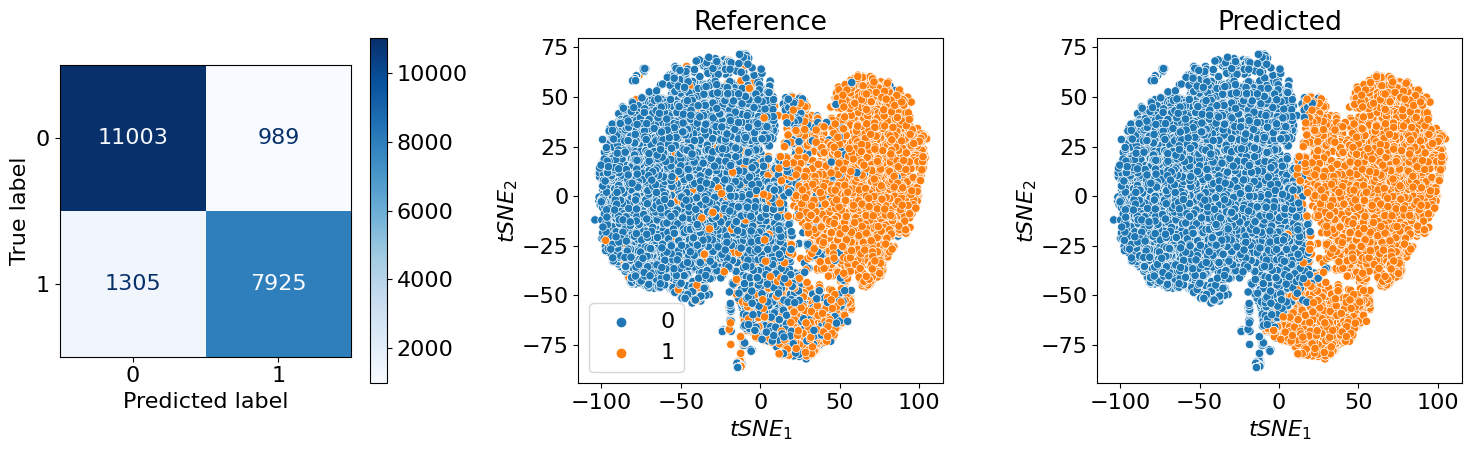

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print('Fold: ',fold, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()